### 小组作业

In [271]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm
import torch.nn.functional as F

In [272]:
batch_size = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 25 
learning_rate = 1e-4


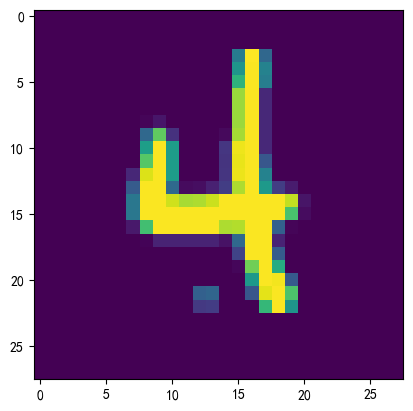

(784, 10000)

In [273]:
# 载入npy文件
data = np.load("train_x.npy")
# 使用Matplotlib可视化数据
ex = data[:,0].reshape((28,28))
plt.imshow(ex)
plt.show()
data.shape

In [274]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 定义卷积层和池化层
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 定义全连接层
        self.fc1 = nn.Linear(7 * 7 * 32, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # 前向传播过程
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x


In [275]:
class SharedEncoder(nn.Module):
    def __init__(self):
        super(SharedEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        return x

class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        
        # 创建共享的卷积部分
        self.shared_encoder = SharedEncoder()
        
        # 创建第一个网络的独有部分
        self.autoencoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),  # (b, 16, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, padding=1),  # (b, 1, 14, 14)
            nn.ReLU()
        )

        self.flatten = nn.Flatten()
        
        # 创建第二个网络的独有部分
        self.cnn = nn.Sequential(
            nn.Linear(7 * 7 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 10)

        )
        
    def forward(self, x):
        # 前向传播过程
        
        # 共享卷积部分
        shared_output = self.shared_encoder(x)

        # 第一个网络的独有部分
        decode = self.autoencoder(shared_output)
        
        #扁平化
        shared_output = self.flatten(shared_output)
        
        
        # 第二个网络的独有部分
        cnn_output = self.cnn(shared_output)
        
        return decode, cnn_output


In [276]:
#数据加载转换tensor类
class CNN_Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)


In [277]:


train_y , test_y = np.load("train_y.npy"),np.load("test_y.npy")
train_x , test_x = np.load("train_x.npy").T.reshape((-1,1,28, 28))/255.0,np.load("test_x.npy").T.reshape((-1,1, 28, 28))
unlabel_train_x = np.load("unlabel_x.npy").T.reshape((-1,1,28, 28))
unlabel_train_x = unlabel_train_x/255.0
final_x = np.load("final_x.npy").T.reshape((-1,1,28, 28))/255.0

train_dataset, test_dataset = CNN_Dataset(
    train_x, train_y), CNN_Dataset(test_x, test_y)

unlabel_train_dataset =  CNN_Dataset(unlabel_train_x)
final_dataset = CNN_Dataset(final_x)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

unlabel_train_loader = DataLoader(
    unlabel_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

final_loader =  DataLoader(
    final_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


In [278]:
model = CombinedModel().to(device)
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)



In [279]:

#训练
def untrainer(unlabel_train_loader, model,n_epochs , device):
    un_loss_record = []
    for epoch in range(n_epochs):
        model.train()  # Set your model to train mode.
        # tqdm is a package to visualize your training progress.
        if epoch in [n_epochs * 0.25, n_epochs * 0.5]:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        train_pbar = tqdm(train_loader, leave=False)
        unlabel_pbar = tqdm(unlabel_train_loader, leave=False)
        for x in unlabel_pbar:
            optimizer.zero_grad()
            x = x.to(device)
            decode , _ = model(x)
            loss = criterion2(x,decode)
            loss.backward()
            optimizer.step()
            un_loss_record.append(loss.detach().item())
        mean_unlabel_loss = sum(un_loss_record)/len(un_loss_record)
        if(epoch+1)%50==0:
            print(f'Epoch[{epoch+1}/{n_epochs}]: unlabelTrain loss: {mean_unlabel_loss: .8f}')
    return un_loss_record

def trainer(train_loader, model,n_epochs , device):
    loss_record = []
    for epoch in range(n_epochs):
        model.train()  # Set your model to train mode.
        # tqdm is a package to visualize your training progress.
        if epoch in [n_epochs * 0.25, n_epochs * 0.5]:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        train_pbar = tqdm(train_loader, leave=False)
        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.type(torch.LongTensor).to(device)  # Move your data to device.
            _,pred = model(x)
            loss = criterion1(pred, y)
            # Compute gradient(backpropagation).
            loss.backward()
            optimizer.step()                    # Update parameters.
            loss_record.append(loss.detach().item())
        mean_train_loss = sum(loss_record)/len(loss_record)
        if(epoch+1)%50==0:
            print(f'Epoch[{epoch+1}/{n_epochs}]: labelTrain loss: {mean_train_loss: .8f}')
    return loss_record

In [280]:
def test(test_loader,model,device):
    model.eval()  # Set your model to evaluation mode.
    loss_record = []
    predictions = []  # 用于存储预测值的列表
    correct = 0
    total = 0
    for x, y in test_loader:
        x, y = x.to(device), y.type(torch.LongTensor).to(device)
        with torch.no_grad():
            _,pred = model(x)
            _, predicted_labels = torch.max(pred.data, 1)  # 获取预测的标签
            predictions.extend(predicted_labels.cpu().numpy())  # 将预测值添加到列表中
            total += y.size(0)  # 累计总样本数量
            correct += (predicted_labels == y).sum().item()  # 统计正确预测的样本数量
            loss = criterion1(pred, y)
        loss_record.append(loss.item())
    mean_test_loss = sum(loss_record)/len(loss_record)
    accuracy = correct / total  # 计算准确率
    print(f'Test loss: {mean_test_loss:.8f}')
    print(f'Accuracy: {accuracy * 100:.2f}%')
    return predictions

In [281]:
def final(final_loader,model,device):
    model.eval()  # Set your model to evaluation mode.
    predictions = []  # 用于存储预测值的列表
    for x in final_loader:
        x = x.to(device)
        with torch.no_grad():
            _,pred = model(x)
            _, predicted_labels = torch.max(pred.data, 1)  # 获取预测的标签
            predictions.extend(predicted_labels.cpu().numpy())  # 将预测值添加到列表中
    return predictions

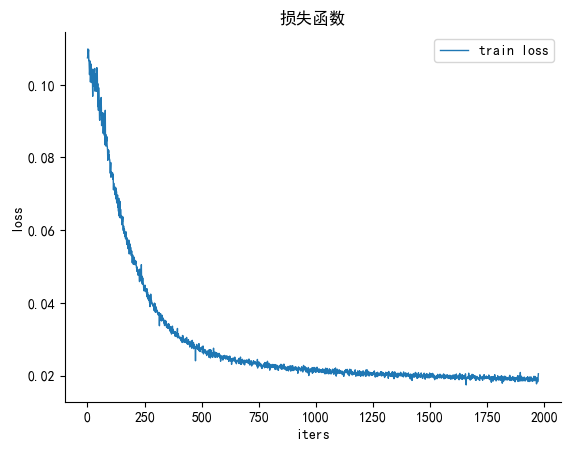

In [282]:
y_train_loss = untrainer(unlabel_train_loader,model,n_epochs,device)     # loss值，即y轴
x_train_loss = range(len(y_train_loss))			 # loss的数量，即x轴
plt.figure()

# 去除顶部和右边框框
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号

plt.xlabel('iters')    # x轴标签
plt.ylabel('loss')     # y轴标签

# 以x_train_loss为横坐标，y_train_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
plt.plot(x_train_loss, y_train_loss, linewidth=1,linestyle="solid", label="train loss")
plt.legend()
plt.title("损失函数")
plt.show()

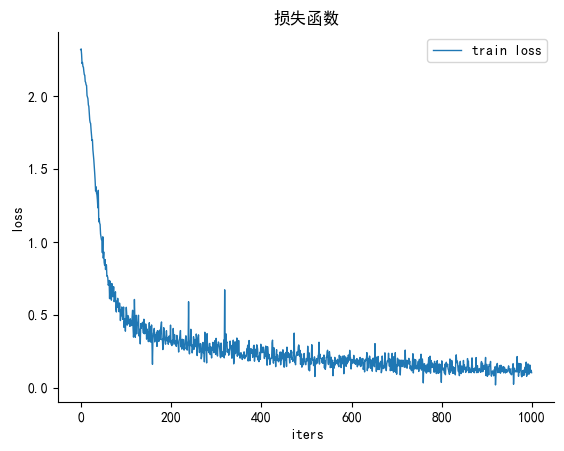

In [283]:
y_train_loss = trainer(train_loader,model,n_epochs,device)     # loss值，即y轴
x_train_loss = range(len(y_train_loss))			 # loss的数量，即x轴
plt.figure()

# 去除顶部和右边框框
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号

plt.xlabel('iters')    # x轴标签
plt.ylabel('loss')     # y轴标签

# 以x_train_loss为横坐标，y_train_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
plt.plot(x_train_loss, y_train_loss, linewidth=1,linestyle="solid", label="train loss")
plt.legend()
plt.title("损失函数")
plt.show()

Test loss: 21.46645594
Accuracy: 95.16%


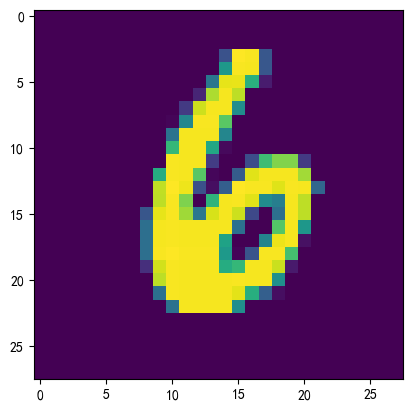

6


In [284]:
predict = test(test_loader,model,device)

ex = np.load("test_x.npy").T[0].reshape((28, 28))
plt.imshow(ex)
plt.show()
print(predict[0])
#成功预测


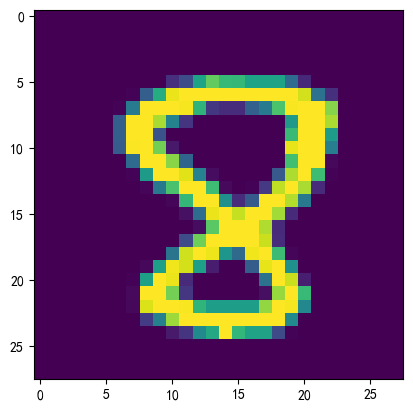

8


In [285]:
finalpre = final(final_loader,model,device)

ex = np.load("final_x.npy").T[0].reshape((28, 28))
plt.imshow(ex)
plt.show()
print(finalpre[0])
#成功预测
np.save("final_y.npy",finalpre)